<a href="https://colab.research.google.com/github/lokeshcv/ComputerVisionDeepLearning/blob/main/pytorch_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.


In [3]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import numpy as np

In [4]:
dir_path = '/content/data'

Load the MNIST dataset from the PyTorch Datasets

In [5]:
train_ds = torchvision.datasets.MNIST(root=dir_path, train=True,
                                      download=True,
                                      transform=ToTensor())

test_ds = torchvision.datasets.MNIST(root=dir_path, train=False,
                                      download=True,
                                      transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

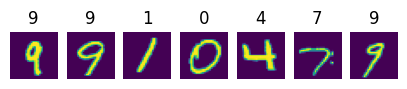

In [28]:
idx = torch.randint(0,len(train_ds), size=(7,), device=device)
figure = plt.figure(figsize=(5,3))
for i, ids in enumerate(idx):
  plt_idx = int(f"17{i+1}")
  figure.add_subplot(plt_idx)
  plt.imshow(train_ds[ids][0][0])
  plt.title(train_ds[ids][1])
  plt.axis('off')
